In [2]:
import pandas as pd
from pathlib import Path
from drevalpy.datasets.curvecurator import preprocess, _exec_curvecurator, postprocess
import drevalpy
drevalpy.__version__

'1.3.6'

## Load Data

In [2]:
RAW_FILE_PATH = Path("RawDataDrugsSingleAgents.txt")

In [3]:
raw_df = pd.read_csv(RAW_FILE_PATH, sep="\t")
# make min dosis and max dosis column: min(D1_CONC, ..., D5_CONC) / max
raw_df['MIN_DOSIS'] = raw_df[['D1_CONC', 'D2_CONC', 'D3_CONC', 'D4_CONC', 'D5_CONC']].min(axis=1)
raw_df['MAX_DOSIS'] = raw_df[['D1_CONC', 'D2_CONC', 'D3_CONC', 'D4_CONC', 'D5_CONC']].max(axis=1)
# kick out BARCODE
raw_df = raw_df.drop(columns=['BARCODE'])
raw_df

,Model,ID,DRUG_ID,D1_CONC,D2_CONC,D3_CONC,D4_CONC,D5_CONC,D1_INTENSITY,D2_INTENSITY,D3_INTENSITY,D4_INTENSITY,D5_INTENSITY,Control,Blank,MIN_DOSIS,MAX_DOSIS
0,HCI001,HCI001-X4C,Camptothecin,0.100000,0.025000,0.00625,0.001563,0.000391,4924,5960,7256,5912,7199,6012.80,56.785714,0.000391,0.1
1,HCI001,HCI001-X4C,Vinblastine,0.100000,0.025000,0.00625,0.001563,0.000391,3644,3434,4648,5939,6364,6012.80,56.785714,0.000391,0.1
2,HCI001,HCI001-X4C,Cisplatin,10.000000,2.500000,0.62500,0.156250,0.039062,2915,6037,5768,5831,5272,6012.80,56.785714,0.039062,10.0
3,HCI001,HCI001-X4C,Gefitinib,0.500000,0.125000,0.03125,0.007812,0.001953,5612,5579,5604,5977,5960,6012.80,56.785714,0.001953,0.5
4,HCI001,HCI001-X4C,ABT-263,2.000000,0.500000,0.12500,0.031250,0.007812,713,2054,3045,4001,4405,6012.80,56.785714,0.007812,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6629,VHIO244,VHIO244-X2C,681640,2.000000,0.500000,0.12500,0.031250,0.007812,23395,34949,40804,40906,39492,41727.25,177.500000,0.007812,2.0
6630,VHIO244,VHIO244-X2C,BMS-708163,0.019531,0.078125,0.31250,1.250000,5.000000,40268,43808,39285,46232,33458,38017.75,195.214286,0.019531,5.0
6631,VHIO244,VHIO244-X2C,BMS-708163,0.019531,0.078125,0.31250,1.250000,5.000000,41871,44815,38164,46148,28406,41727.25,177.500000,0.019531,5.0
6632,VHIO244,VHIO244-X2C,SCH772984,0.019531,0.078125,0.31250,1.250000,5.000000,47256,54170,40172,853,334,38017.75,195.214286,0.019531,5.0


In [4]:
# transform to long format: Keep: Model, ID, DRUG_ID, Control, Blank. Match up: D1_CONC + D1_INTENSITY, D2_CONC + D2_INTENSITY, ...
raw_df.columns = ['Model', 'ID', 'DRUG_ID', 'CONC1', 'CONC2', 'CONC3', 'CONC4', 'CONC5', 'INTENSITY1', 'INTENSITY2', 'INTENSITY3', 'INTENSITY4', 'INTENSITY5', 'Control', 'Blank', 'mindose', 'maxdose']
raw_df_long = pd.wide_to_long(
    df=raw_df,
    stubnames=['CONC', 'INTENSITY'],
    j="MEASURE_NUM",
    i=['Model', 'ID', 'DRUG_ID', 'Control', 'Blank', 'mindose', 'maxdose'],
)

In [5]:
# In the paper, the observed response was computed as: 1 – (intensity-negative control)/(positive control – negative control).
# -> higher response = lower intensity because more dead cells.
# we want viability -> no 1-
raw_df_long = raw_df_long.reset_index()
raw_df_long['response'] = (raw_df_long['INTENSITY'] - raw_df_long['Blank'])/(raw_df_long['Control'] - raw_df_long['Blank'])

## Creating replicate information

In [6]:
# we will treat the 'ID' as cell line ID. 'MODEL' means that it comes from the same original tumor sample. 'ID' means the same mouse, i.e., if the same tumor sample is subsequently implanted into different mice (passages). We count technical replicates
raw_df_long['replicate'] = raw_df_long.groupby(['Model', 'ID', 'DRUG_ID', 'CONC']).cumcount()
raw_df_long['nreplicates'] = raw_df_long.groupby(['Model', 'ID', 'DRUG_ID'])['replicate'].transform('max')
# sort by ID, DRUG_ID
raw_df_long = raw_df_long.sort_values(by=['ID', 'DRUG_ID'])
raw_df_long = raw_df_long.reset_index()

In [7]:
drug_dosages = raw_df_long[["ID", "DRUG_ID", "mindose", "maxdose"]].drop_duplicates()
drug_dosages.to_csv("drug_dosages_Bruna.csv", index=False)

### Drug name to PubChem mapping

In [8]:
import pubchempy as pcp
results = {}
chembls = {}
manual_review = {}
inchis = {}
i = 0
for drug in raw_df_long['DRUG_ID'].unique():
    if i % 10 == 0:
        print(i, '/', len(raw_df_long['DRUG_ID'].unique()))
    compounds = pcp.get_compounds(identifier=drug, namespace="name")
    if len(compounds) == 0:
        manual_review[drug] = [compounds]
    else:
        results[drug] = compounds[0].cid
        inchis = compounds[0].inchi
        chembl = None
        for syn in compounds[0].synonyms or []:
            if syn.startswith("CHEMBL"):
                chembl = syn
                break
        chembls[drug] = chembl
    i += 1

0 / 104
10 / 104
20 / 104
30 / 104
40 / 104
50 / 104
60 / 104
70 / 104
80 / 104
90 / 104
100 / 104


In [9]:
print(f'{len(results)} matches, {len(manual_review)} not found')
manual_review |= {brd: cid for brd, cid in results.items() if cid is None}
manual_review

101 matches, 3 not found


{'681640': [[]],
 'GW843682X (AN-13)': [[]],
 'Olaparib(1495) + Temozolomide(1375)': [[]]}

In [10]:
manual_review['681640'] = 'Bruna_681640'
manual_review['GW843682X (AN-13)'] = '9826308'
manual_review['Olaparib(1495) + Temozolomide(1375)'] = '23725625_5394'

In [11]:
def sanitize(val):
    if isinstance(val, int):
        return str(val)
    if isinstance(val, list):
        return ','.join([str(i) for i in val])
    return val
cids = pd.Series(results | manual_review, name="CID").apply(sanitize).astype(str)
cids

17-AAG                                       6505803
ABT-263                                     24978538
AMG-706                                     11667893
AZ628                                       11676786
AZD2281                                     23725625
                                           ...      
NVP-AUY922                                 135539077
RI-1                                         1074953
681640                                  Bruna_681640
GW843682X (AN-13)                            9826308
Olaparib(1495) + Temozolomide(1375)    23725625_5394
Name: CID, Length: 104, dtype: object

In [12]:
chembls = pd.Series(chembls, name="CHEMBL")
full_df = raw_df_long.merge(cids, left_on='DRUG_ID', right_index=True).merge(chembls, left_on='DRUG_ID', right_index=True, how='left')
# The required columns are "dose", "response", "sample", and "drug", with an optional "replicate" column.
full_df.rename(columns={'Model': 'Mouse_ID', 'ID': 'sample', 'DRUG_ID': 'drug_name', 'CONC': 'dose', 'CID': 'drug'}, inplace=True)
full_df.to_csv('viabilities_processed.csv', index=None)
full_df

,index,Mouse_ID,sample,drug_name,Control,Blank,mindose,maxdose,MEASURE_NUM,dose,INTENSITY,response,replicate,nreplicates,drug,CHEMBL
0,70,HCI001,HCI001-X4C,17-AAG,6012.80,56.785714,0.003906,1.0,1,1.000000,4227,0.700169,0,3,6505803,None
1,71,HCI001,HCI001-X4C,17-AAG,6012.80,56.785714,0.003906,1.0,2,0.250000,3596,0.594225,0,3,6505803,None
2,72,HCI001,HCI001-X4C,17-AAG,6012.80,56.785714,0.003906,1.0,3,0.062500,4470,0.740968,0,3,6505803,None
3,73,HCI001,HCI001-X4C,17-AAG,6012.80,56.785714,0.003906,1.0,4,0.015625,4515,0.748523,0,3,6505803,None
4,74,HCI001,HCI001-X4C,17-AAG,6012.80,56.785714,0.003906,1.0,5,0.003906,4697,0.779080,0,3,6505803,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33165,32335,VHIO244,VHIO244-X2C,mirin,37889.25,186.142857,0.390625,100.0,1,100.000000,10579,0.275650,1,1,1206243,None
33166,32336,VHIO244,VHIO244-X2C,mirin,37889.25,186.142857,0.390625,100.0,2,25.000000,30034,0.791655,1,1,1206243,None
33167,32337,VHIO244,VHIO244-X2C,mirin,37889.25,186.142857,0.390625,100.0,3,6.250000,41931,1.107199,1,1,1206243,None
33168,32338,VHIO244,VHIO244-X2C,mirin,37889.25,186.142857,0.390625,100.0,4,1.562500,39012,1.029779,1,1,1206243,None


### DrEvalPy: run CurveCurator

In [13]:
preprocess(input_file='viabilities_processed.csv', output_dir='curvecurator', dataset_name='Bruna', cores=6, normalize=False)

In [14]:
_exec_curvecurator(Path('curvecurator'))

In [15]:
postprocess('curvecurator', dataset_name='Bruna')

## Postprocess for Zenodo

* Quality control
* Set EC50s outside the measured range to NaN
* Set IC50s outside 10*max/10**-1 min measured range to NaN


In [3]:
viability_df = pd.read_csv('curvecurator/Bruna.csv', converters={'sample': str, 'pubchem_id': str})
full_df = pd.read_csv('viabilities_processed.csv', converters={'drug': str})[['sample', 'drug', 'drug_name', 'CHEMBL', 'mindose', 'maxdose', ]].drop_duplicates()
viability_df = viability_df.merge(full_df, left_on=['cell_line_name', 'pubchem_id'], right_on=['sample', 'drug'])
viability_df

,Name,SignalQuality,pEC50_curvecurator,Slope,Front,Back,FoldChange,AUC_curvecurator,RMSE,R2,...,pubchem_id,EC50_curvecurator,IC50_curvecurator,LN_IC50_curvecurator,sample,drug,drug_name,CHEMBL,mindose,maxdose
0,HCI009-X4C|135440466,0.0,0.598739,0.238243,1.000859,0.683063,-0.337450,0.842100,0.035170,0.725057,...,135440466,0.251919,NaN,NaN,HCI009-X4C,135440466,BMS-536924,CHEMBL401930,0.015625,4.00
1,HCI009-X4C|17755052,0.0,0.602849,1.671565,0.896144,0.050977,-4.081165,0.473289,0.083464,0.945546,...,17755052,0.249546,0.231525,-1.463068,HCI009-X4C,17755052,GDC0941,CHEMBL521851,0.015625,4.00
2,HCI009-X4C|24964624,0.0,0.738182,1.431841,1.040706,0.068315,-3.645787,0.501649,0.038172,0.990434,...,24964624,0.182734,0.213854,-1.542460,HCI009-X4C,24964624,MK-2206,CHEMBL1079175,0.015625,4.00
3,HCI009-X4C|5330286,0.0,3.806180,10.000000,1.000000,0.849883,-0.234664,0.849883,0.076041,0.243622,...,5330286,0.000156,NaN,NaN,HCI009-X4C,5330286,PD-0332991,CHEMBL189963,0.015625,4.00
4,HCI009-X4C|9914412,0.0,-0.677599,9.997306,0.929197,0.377066,-0.240115,0.927584,0.052754,0.266856,...,9914412,4.759914,5.394014,1.685290,HCI009-X4C,9914412,ZM-447439,CHEMBL202721,0.015625,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2554,VHIO169-X3C|11707110,0.0,1.843174,10.000000,1.111350,0.680326,-0.555702,0.781461,0.067750,0.890738,...,11707110,0.014349,NaN,NaN,VHIO169-X3C,11707110,GSK1120212,CHEMBL2103875,0.003906,1.00
2555,VHIO169-X3C|135565545,0.0,0.938530,10.000000,1.010331,0.927741,-0.108207,0.978144,0.025476,0.699875,...,135565545,0.115205,NaN,NaN,VHIO169-X3C,135565545,PF477736,CHEMBL3990456,0.003906,1.00
2556,VHIO169-X3C|6914657,0.0,2.504405,2.758236,1.000000,0.030761,-5.022765,0.058244,0.000325,0.999999,...,6914657,0.003130,0.003203,-5.743586,VHIO169-X3C,6914657,FK866,CHEMBL566757,0.003906,1.00
2557,STG335-X1C|387447,0.0,2.438501,10.000000,1.008668,0.000100,-13.287127,0.698953,0.090343,0.963795,...,387447,0.003643,0.003650,-5.613116,STG335-X1C,387447,Bortezomib,CHEMBL325041,0.000078,0.02


In [4]:
# join with original data
original_measures_df = pd.read_csv('DrugResponsesAUCSamples.txt', sep='\t')
original_measures_df = original_measures_df.drop(columns=['Model', 'D1_CONC', 'D5_CONC', 'perc.iC50', 'cluster.superv'])
viability_df = viability_df.merge(original_measures_df, left_on=['cell_line_name', 'drug_name'], right_on=['ID', 'Drug'])


<Axes: xlabel='AUC_curvecurator', ylabel='AUC'>

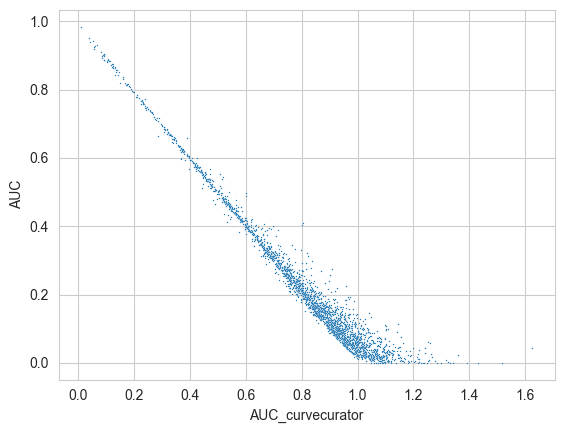

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# checks out because they measure AUC=area under the dose response curve, we measure AUC=area under the dose viability curve
sns.scatterplot(viability_df, x="AUC_curvecurator", y="AUC", s=1)

<Axes: xlabel='AUC_curvecurator', ylabel='AUC'>

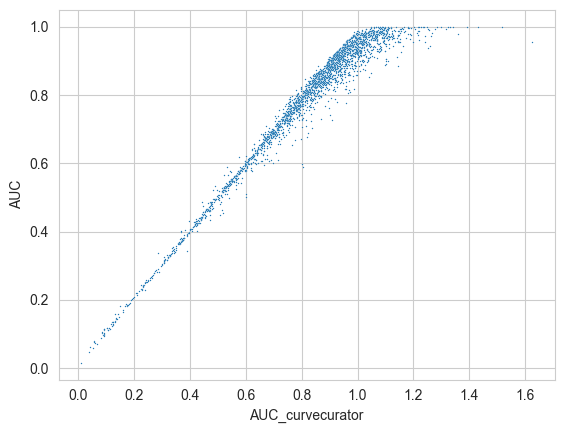

In [6]:
viability_df["AUC_dose_response"] = viability_df["AUC"]
viability_df["AUC"] = 1-viability_df["AUC"]
sns.scatterplot(viability_df, x="AUC_curvecurator", y="AUC", s=1)

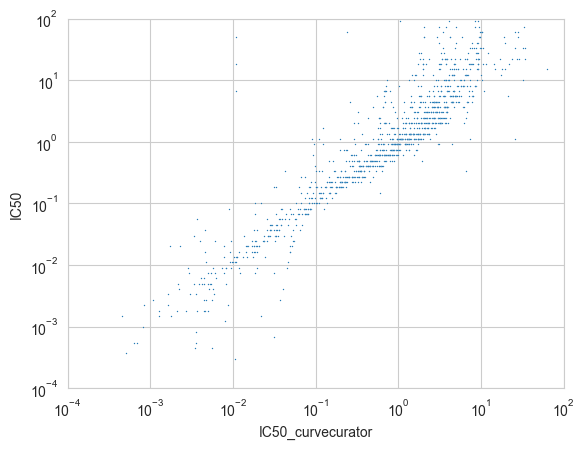

In [7]:
viability_df = viability_df.rename(columns={'iC50': 'IC50'})
sns.scatterplot(viability_df, x="IC50_curvecurator", y="IC50", s=1)
plt.xlim(1e-4, 1e2)
plt.ylim(1e-4, 1e2)
plt.xscale('log')
plt.yscale('log')

In [8]:
viability_df["min_dose_M"] = 10**-6 * viability_df["mindose"]
viability_df["max_dose_M"] = 10**-6 * viability_df["maxdose"]

In [9]:
def plot_curve(df, index):
    # plot is in M -> change units that need to be changes
    front = df.loc[index, "Front"] # unitless
    back = df.loc[index, "Back"] # unitless
    ec50 = df.loc[index, "EC50_curvecurator"] * 10**-6 # transform from µM to M

    slope = df.loc[index, "Slope"] # unitless
    ic50 = df.loc[index, "IC50_curvecurator"] * 10**-6 # transform from µM to M
    origAUC = df.loc[index, "AUC"] # unitless
    origic50 = df.loc[index, "IC50"] * 10**-6

    min_dosis = df.loc[index, "min_dose_M"]
    max_dosis = df.loc[index, "max_dose_M"]

    # curve fit: (front-back)/(1+(x/EC50)^slope) + back = (front-back) / (1+10^(slope*(log10(x)-log10(EC50)) + back; -log10(EC50) = pEC50
    xvals = 10**np.linspace(np.log10(min_dosis)-2, np.log10(max_dosis)+2, 1000)
    xvals_logged = np.log10(xvals)
    y = (front - back) / (1 + 10 ** (slope * (xvals_logged -np.log10(ec50)))) + back
    plt.scatter(xvals, y, s=1)

    plt.axvline(origic50, linestyle='--')
    plt.text(x=origic50, y=0.8, s='IC50 orig', color='blue')
    plt.axvline(ic50, color="red")
    plt.text(x=ic50, y=1.0, s='IC50 curvecurator', color='red')
    plt.axvline(ec50, color="orange")
    plt.text(x=ec50, y=0.6, s='EC50 curvecurator', color='orange')
    plt.axvline(x=min_dosis, color="green")
    plt.text(x=min_dosis, y=0.4, s='min dose [M]', color='green')
    plt.axvline(x=max_dosis, color="green")
    plt.text(x=max_dosis, y=0.4, s='max dose [M]', color='green')

    auc = df.loc[index, "AUC_curvecurator"]
    plt.title(f"AUC: {auc}, Original AUC: {origAUC}")

    plt.axhline(0.5, linestyle='--', color='black')
    plt.xscale('log')
    plt.xlim(min_dosis*10**-2, max_dosis*10**2)
    plt.ylim(0, 2)

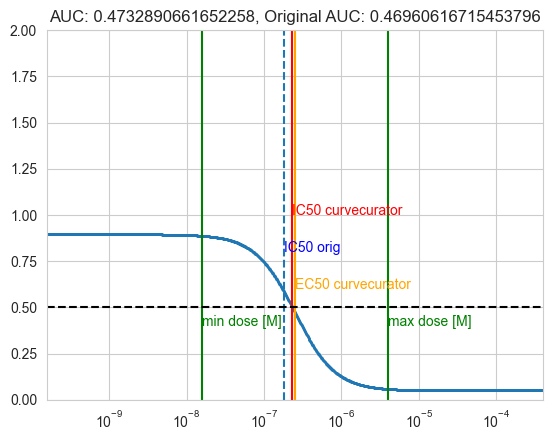

In [10]:
plot_curve(viability_df, 1)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


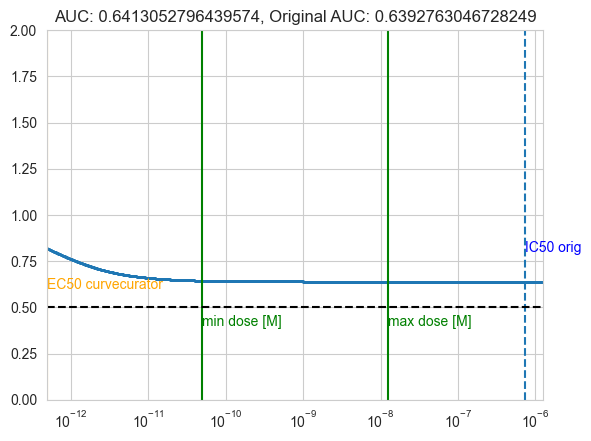

In [11]:
# curvecurator caps EC50s at 10**2 max dose/10**-2 min dose but we want to set them to NaN if they are outside the measured range
plot_curve(viability_df,1499)

In [12]:
# pEC50 = -log10(dosis[µM]); allow 10^-1 to 10^2 times the min/max dose for IC50
drug_dosages = pd.read_csv("drug_dosages_Bruna.csv")
min_doses_pEC50 = {f'{row["ID"]}|{row["DRUG_ID"]}': -np.log10(row["mindose"]) for index, row in drug_dosages.iterrows()}
max_doses_pEC50 = {f'{row["ID"]}|{row["DRUG_ID"]}': -np.log10(row["maxdose"]) for index, row in drug_dosages.iterrows()}
min_doses_IC50 = {f'{row["ID"]}|{row["DRUG_ID"]}': 10**-1 * row["mindose"] for index, row in drug_dosages.iterrows()}
max_doses_IC50 = {f'{row["ID"]}|{row["DRUG_ID"]}': 10**2 * row["maxdose"] for index, row in drug_dosages.iterrows()}

num_pEC50s_nan = viability_df["pEC50_curvecurator"].isna().sum()
num_ic50s_nan = viability_df["IC50_curvecurator"].isna().sum()

new_pEC50s = viability_df.apply(lambda x: x["pEC50_curvecurator"] if min_doses_pEC50[f"{x['cell_line_name']}|{x['drug_name']}"] >= x["pEC50_curvecurator"] >= max_doses_pEC50[f"{x['cell_line_name']}|{x['drug_name']}"] else np.nan, axis=1)

new_IC50s = viability_df.apply(lambda x: x["IC50_curvecurator"] if min_doses_IC50[f"{x['cell_line_name']}|{x['drug_name']}"] <= x["IC50_curvecurator"] <= max_doses_IC50[f"{x['cell_line_name']}|{x['drug_name']}"] else np.nan, axis=1)

In [13]:
viability_df["pEC50_curvecurator"] = new_pEC50s
viability_df["IC50_curvecurator"] = new_IC50s
print(f"From {num_pEC50s_nan} to {viability_df['pEC50_curvecurator'].isna().sum()} NaN pEC50s / {len(viability_df)}")
print(f"From {num_ic50s_nan} to {viability_df['IC50_curvecurator'].isna().sum()} NaN IC50s / {len(viability_df)}")

From 0 to 612 NaN pEC50s / 2559
From 1046 to 1087 NaN IC50s / 2559


In [14]:
# the pEC50 is off by 6 because of the new package version (switch from M to uM)
viability_df["pEC50_curvecurator"] = viability_df["pEC50_curvecurator"] + 6

In [15]:
viability_df.to_csv("PDX_Bruna.csv", index=False)